In [1]:
# Import numpy and matplotlib, and use jupyter magic to
# get plots directly in notebook
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
# Timer to measure the performance of methods
from time import time
from tqdm.notebook import trange
from scipy.stats import norm
from numba import jit

# Stochastic differential equations

Stochastic differential equations (SDEs) are differential equations that describe processes which develop with some element of randomness. A random walk is an example of such a process, but SDEs can also describe a range of other processes with different statistical properties.

We will not go into the mathematical details of SDEs, but we will look at a few simple examples, and how they can be solved numerically.

If you are interested in further details, there are a couple of courses offered by the department of mathematics:
* MA8109 - Stochastic Processes and Differential Equations, is a quite theoretical/mathematical course
* MA8404 - Numerical solution of time dependent differential equations, deals with both ordinary and stochastic differential equations

I can also recommend the book *Numerical Solution of Stochastic Differential Equations* by Kloeden & Platen:
* https://link.springer.com/book/10.1007/978-3-662-12616-5

## Random walk

The simplest form of a random walk is one that makes a number of steps, all of the same length, but with the direction chosen at random. In one dimension, the position after $N$ steps is then given by

$$ x_N = \sum_{i=0}^N L_i, $$

where the steps, $L_i$ are either $+L$ or $-L$, with equal probability.

Text(0, 0.5, 'Position')

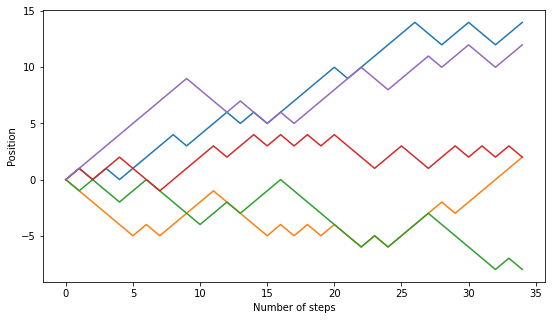

In [2]:
N = 35
L = 1

# Array to hold 5 random walkers
walkers = np.zeros((N, 5))

# Construct the walks explicity with a for loop,
# with the position after each step equal to the position
# after the previous step, plus a random increment
# (either +L or -L, with equal probability)
for i in range(1, N):
    walkers[i,:] = walkers[i-1,:] + np.random.choice([-L, +L], size = 5)
    
# Plot position as function of "time"
fig = plt.figure(figsize = (9, 5))
plt.plot(walkers)
plt.xlabel('Number of steps')
plt.ylabel('Position')

## Distribution of random walkers

Next, we will look at the distribution when we consider a large number of random walkers. To investigate the distribution, we will use a histogram of positions at different times. It turns out that the distribution is Gaussian, with the probability distribution after $n$ random steps of length $L$ is given by

$$ p(x, n) = \frac{1}{\sigma_n\sqrt{2\pi}} \exp \left( -\frac{1}{2} \frac{x^2}{\sigma_n^2} \right), $$

where $\sigma_n = L\sqrt{n}$, and hence the variance of the distribution is given by $\sigma_n^2 = n L^2$.

The fact that the variance (or mean square displacement) increases linearly with the number of steps is a characteristic feature of random walks, and as we shall see, also of diffusion.

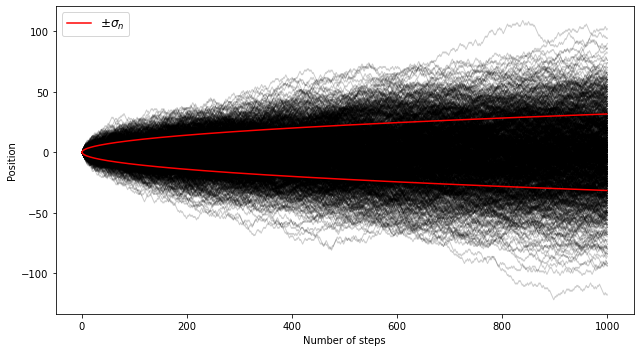

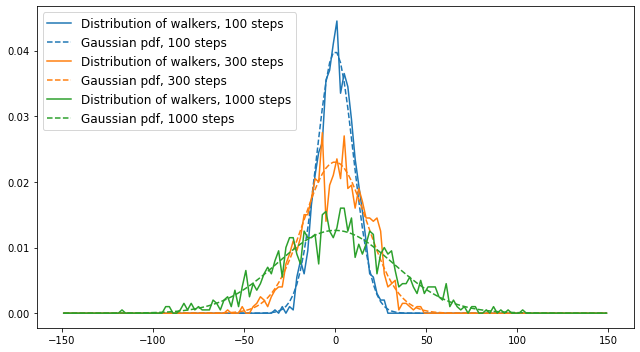

In [3]:
N  = 1000 # Number of steps
Np = 1000 # Number of walkers, or "particles"
L  = 1 # Length of each step

# Array to hold Np random walkers, each with N steps
walkers = np.zeros((N+1, Np))

# Construct the walks by cumulative sum
walkers[1:,:] = np.cumsum( np.random.choice([-L, +L], size = (N,Np)), axis = 0)
    
# Plot position as function of "time"
fig = plt.figure(figsize = (9, 5))

plt.plot(walkers, c = 'k', alpha = 0.2, lw = 1)
plt.plot(np.arange(N), L*np.sqrt(np.arange(N)), c = 'r', label = '$\pm \sigma_n$')
plt.plot(np.arange(N), -L*np.sqrt(np.arange(N)), c = 'r')
plt.xlabel('Number of steps')
plt.ylabel('Position')
plt.legend(fontsize = 12)
plt.tight_layout()


# Analytical solution
pdf = lambda x, n: np.exp(-x**2/(2*L**2*n))/(L*np.sqrt(2*np.pi*n))

# Create histogram of distribution, at different times
# and plot with the analytical solution
fig = plt.figure(figsize = (9, 5))
bins, dx = np.linspace(-150, 150, 151, retstep = True)
mids = bins[:-1] + dx/2
for i in [100, 300, 1000]:
    hist, _ = np.histogram(walkers[i,:], bins = bins, density = True)
    l, = plt.plot(mids, hist, label = f'Distribution of walkers, {i} steps')
    plt.plot(mids, pdf(mids, i), '--', c = l.get_color(), label = f'Gaussian pdf, {i} steps')

plt.legend(loc = 'upper left', fontsize = 12)
plt.tight_layout()

## Intermezzo: The diffusion equation

Variance that increases linearly in time also happens to be a property of the diffusion equation:

In [4]:
from scipy.sparse import diags
from scipy.integrate import simps

In [5]:
# Diffusion parameter
K = 0.5

# Specify domain
Nx = 1001
X, dx = np.linspace(0, 100, Nx, retstep = True)

# Specify time and timestep
Nt = 10001
T, dt = np.linspace(0, 100, Nt, retstep = True)

# Check stability condition for this method
print(f'K*dt/dx**2 = {K*dt/dx**2}')

# Set up matrix for the right-hand side,
# using sparse diagonal matrix structure
alpha = K*dt/dx**2
sub_diag = alpha * np.ones(Nx-1)
main_diag = 1 - 2*alpha * np.ones(Nx)
super_diag = alpha * np.ones(Nx-1)
# Change two elements to account for boundary conditions
super_diag[0] = 2*alpha
sub_diag[-1] = 2*alpha
R = diags((sub_diag, main_diag, super_diag), offsets = (-1, 0, 1))

# Initial value, a couple of Gaussians:
mu1, sigma1 = 46, 4
mu2, sigma2 = 54, 2
C0 = 0.5 *( (1/(sigma1*np.sqrt(2*np.pi))) * np.exp(-((X - mu1)/sigma1)**2 / 2) \
           + (1/(sigma2*np.sqrt(2*np.pi))) * np.exp(-((X - mu2)/sigma2)**2 / 2) )

# Array to hold solution at all times
C = np.zeros((Nt, len(X)))
# Insert initial values
C[0,:] = C0

# Loop over time
for i in range(1, Nt):
    # Calculate matrix-vector product on right-hand side
    C[i,:] = R.dot(C[i-1,:])

K*dt/dx**2 = 0.4999999999999999


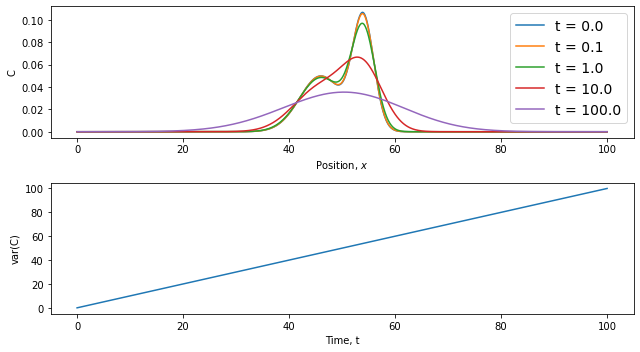

In [6]:
# Plot the solution at a few different times:
timesteps = [0, 10, 100, 1000, 10000]

fig, ax = plt.subplots(nrows = 2, figsize = (9, 5))

# Plot concentration at different times
for it in timesteps:
    ax[0].plot(X, C[it,:], label = f't = {it*dt}')
    
ax[0].set_xlabel('Position, $x$')
ax[0].set_ylabel('C')
ax[0].legend(fontsize = 14)


# Plot variance as a function of time
mu = 50 # The center of mass is 50, see C0 above
var = simps(C*(X - mu)**2, x = X, axis = 1)
ax[1].plot(T, var - var[0])
ax[1].set_xlabel('Time, t')
ax[1].set_ylabel('var(C)')

plt.tight_layout()

## The Wiener process

Above, we defined a random walk as a series of steps of constant length. Now, we will look at the Wiener process, which is a way of generalising the random walk to a continuous function of time.

The Wiener process, $W_t$, is the starting point for a discussion of SDEs. The Wiener process is also sometimes called Brownian motion, and is inspired by (but not identical to) the physical Brownian motion, which was described by botanist Robert Brown in 1827. He observed that small particles (pollen and small mineral grains) in water appeared to move around randomly, and never come to complete rest. This was later explained by Einstein as having to do with the random motion of atoms, and Einstein's equation were later combined with experimental observations of Brownian motion to provide the first estimates of Bolzmann's constant and Avogadro's numebr. See, e.g.,
* https://sciweb.nybg.org/science2/pdfs/dws/Brownian.pdf
* https://archive.org/details/investigationson00eins

The Wiener process is a stochastic process, with the following properties:
* $W_{t=0} = 0$
* Independent increments: $W_s - W_t$ for $s>t$ is independent of any $W_{t'}$ for $t' \leq t$.
* Gaussian increments: $W_{t+\Delta t} - W_t$ is a Gaussian random variable with zero mean and variance $\Delta t$.
* Continuous sample path: $W_t$ is a continuous function of $t$, almost surely.

So what does this mean, and how can we use this in numerical calculations?

We can construct a discrete realisation of a Wiener process with a desired stepsize $\Delta t$ by using the above properties. If we generate independent Gaussian random numbers, with variance $\Delta t$, then they are by definition the increments of a Wiener process, which means that if we take the cumulative sum of these numbers, we get a discrete approximation of a Wiener process.

Below, we plot three different realisations of a Wiener process.

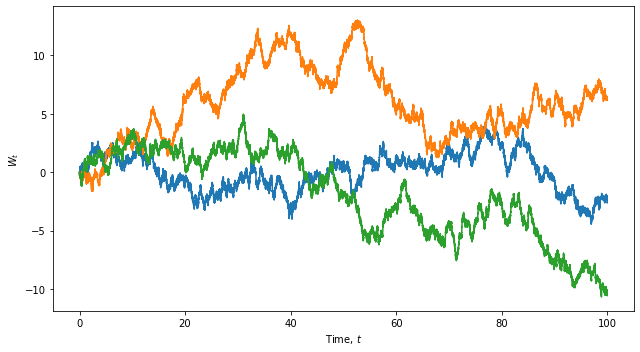

In [7]:
dt = 0.001
Tmax = 100
Nt = int(Tmax/dt)+1

# Time
t = np.linspace(0, Tmax, Nt)

# Wiener process:
#  * First element is zero
#  * The following elements are the cumulative sum
#    of Gaussian random numbers with variance = dt,
#    which means standard deviation = sqrt(dt).
W = np.zeros((Nt, 3))
W[1:,:] = np.cumsum( np.random.normal(loc = 0, scale = np.sqrt(dt), size = (Nt-1, 3)), axis =0)

# Plot the three different realisations
fig = plt.figure(figsize = (9, 5))
plt.plot(t, W)
plt.xlabel('Time, $t$')
plt.ylabel('$W_t$')
plt.tight_layout()

## Variance is linear in time

If we make a large number of Wiener processes, we can take the variance as a function of time, and confirm that it increases linearly, as it should: By the definition above, we should have 
$$ \mathrm{var}( W_t - W_0 ) = t.$$

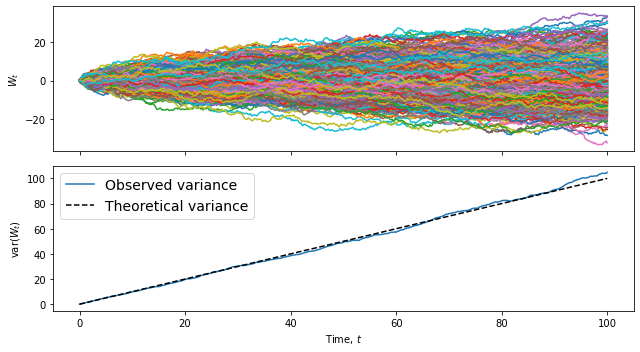

In [8]:
dt = 0.2
Tmax = 100
Nt = int(Tmax/dt)+1

# Time
t = np.linspace(0, Tmax, Nt)

# 1000 Wiener processes:
N = 1000
W = np.zeros((Nt, N))
W[1:,:] = np.cumsum( np.random.normal(loc = 0, scale = np.sqrt(dt), size = (Nt-1, N)), axis =0)

# Plot the three different realisations
fig, ax = plt.subplots(nrows = 2, figsize = (9, 5), sharex = True)
ax[0].plot(t, W)
ax[0].set_ylabel('$W_t$')

ax[1].plot(t, np.var(W, axis = 1), label = 'Observed variance')
ax[1].plot(t, t, '--', c = 'k', label = 'Theoretical variance')
ax[1].set_xlabel('Time, $t$')
ax[1].set_ylabel('$\mathrm{var}(W_t)$')
ax[1].legend(fontsize = 14)
plt.tight_layout()

In [9]:
# We can also take the increments of the Wiener process,
# and recover the original random numbers:

it = 10
n = 1
dW = W[it + n, :] - W[it,:]

print(f'n = {n}')
print(f'Theoretical variance, n*dt:  {n*dt}')
print(f'Variance of increments:      {np.var(dW):.4f}')
print()

it = 10
n = 5
dW = W[it + n, :] - W[it,:]

print(f'n = {n}')
print(f'Theoretical variance, n*dt:  {n*dt}')
print(f'Variance of increments:      {np.var(dW):.4f}')

n = 1
Theoretical variance, n*dt:  0.2
Variance of increments:      0.2047

n = 5
Theoretical variance, n*dt:  1.0
Variance of increments:      1.0606


## Equivalence between Wiener process and diffusion equation

If we create a large number of Wiener processes, then their probability distribution, $p(x, t)$, will develop as described by the following diffusion equation:

$$ \frac{\partial p}{\partial t} = \frac{1}{2} \frac{\partial^2 p}{\partial x^2}. $$

The analytical solution to this equation, if $p(x, t=0) = \delta(x)$, is a Gaussian distribution with variance  $\sigma^2 = t$:

$$ p(x, t) = \frac{1}{\sqrt{2\pi t}} \exp \left( -\frac{x^2}{2t} \right). $$

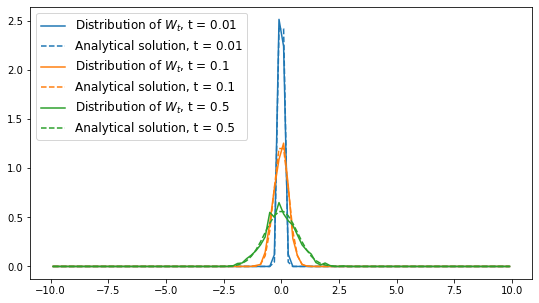

In [10]:
dt = 0.01
Tmax = 10
Nt = int(Tmax/dt)+1

# Time
t = np.linspace(0, Tmax, Nt)

# 1000 Wiener processes:
N = 1000
W = np.zeros((Nt, N))
W[1:,:] = np.cumsum( np.random.normal(loc = 0, scale = np.sqrt(dt), size = (Nt-1, N)), axis=0)

# Analytical solution
pdf = lambda x, t: np.exp(-x**2/(2*t))/(np.sqrt(2*np.pi*t))

# Create histogram of distribution, at different times
# and plot with the analytical solution
fig = plt.figure(figsize = (9, 5))
bins, dx = np.linspace(-10, 10, 101, retstep = True)
mids = bins[:-1] + dx/2
for i in [1, 10, 50]:
    hist, _ = np.histogram(W[i,:], bins = bins, density = True)
    l, = plt.plot(mids, hist, label = f'Distribution of $W_t$, t = {i*dt}')
    plt.plot(mids, pdf(mids, i*dt), '--', c = l.get_color(), label = f'Analytical solution, t = {i*dt}')

plt.legend(loc = 'upper left', fontsize = 12)

# More general diffusion problems, with non-constant diffusivity

Say you have a diffusion problem with variable diffusivity, described by

$$ \frac{\partial p}{\partial t} = \frac{\partial}{\partial x} \left( K(x) \frac{\partial p}{\partial x} \right). $$

Can we also find a stochastic process that will develop according to the probability distribution $p$ also in this case?

Yes, it is given by the solution of the stochastic differential equation (SDE)

$$ \mathrm{d} x = \frac{\partial K(x)}{\partial x} \, \mathrm{d}t + \sqrt{2K(x)} \, \mathrm{d}W. $$

This equation describes a continuous process, but just like for ordinary differential equations, there exist numerous ways to obtain a discrete, numerical approximation to the solution. The simplest one is called the Euler-Maruyama scheme, and simply says

$$ x_{i+1} =  x_i + \frac{\partial K(x)}{\partial x} \, \Delta t + \sqrt{2K(x)} \, \Delta W, $$

where $\Delta W$ are Gaussian random numbers with zero mean and variance $\Delta t$.

In [11]:
# Compiling this function with numba gains a speedup
# of about a factor 10 - 100 (depends on problem size)
@jit(nopython = True)
def tdma_solver(a, b, c, d):
    # Solves Ax = d,
    # where layout of matrix A is
    # b1 c1 ......... 0
    # a2 b2 c2 ........
    # .. a3 b3 c3 .....
    # .................
    # .............. cN-1
    # 0 ..........aN bN
    # Note index offset of a
    N = len(d)
    # Make to extra arrays to avoid overwriting input
    c_ = np.zeros(N-1)
    d_ = np.zeros(N)
    x  = np.zeros(N)
    c_[0] = c[0]/b[0]
    d_[0] = d[0]/b[0]
    for i in range(1, N-1):
        q = (b[i] - a[i-1]*c_[i-1])
        c_[i] = c[i]/q
        d_[i] = (d[i] - a[i-1]*d_[i-1])/q
    d_[N-1] = (d[N-1] - a[N-2]*d_[N-2])/(b[N-1] - a[N-2]*c_[N-2])
    x[-1] = d_[-1]
    for i in range(N-2, -1, -1):
        x[i] = d_[i] - c_[i]*x[i+1]
    return x

def tdma(A, b):
    # Solves Ax = b to find x
    # This is a wrapper function, which unpacks
    # A from a sparse array structure into separate diagonals,
    # and passes them to the numba-compiled solver defined above.
    x = tdma_solver(A.diagonal(-1), A.diagonal(0), A.diagonal(1), b)
    return x

def diffusion_CrankNicolson(X, C0, K, dt, Tmax):
    
    # Numerical parameters
    dx = X[1] - X[0]
    Nx = X.size
    Nt = int(Tmax / dt)
    alpha = dt/(2*dx**2)
    beta  = dt/2

    # Problem arrays
    C      = np.zeros((Nt+1, Nx))
    C[0,:] = C0
    # Diffusivity (here constant in time)
    K      = K(X, 0)
    # Derivative of diffusivity (here constant in time)
    # leaving out 1/2dx, which comes in via alpha
    K_       = np.zeros(Nx)
    K_[1:-1] = (K[2:] - K[:-2])# / (2*dx)
    K_[0]    = 2*(K[ 1] - K[0]  )# / (2*dx)
    K_[-1]   = 2*(K[-1] - K[-2 ])# / (2*dx)

    ####       Create system matrices       ####
    ####    Equation is L C^{i+1} = R C^i   ####
    # Left hand side
    L = np.zeros((Nx, Nx))
    # Superdiagonal
    superdiag = -(alpha/4)*K_[:-1] - alpha*K[:-1]
    maindiag  =  2*alpha*K
    subdiag   =  (alpha/4)*K_[ 1:] - alpha*K[ 1:]
    # Overwrite boundary points
    # No-diffusive-flux BC
    superdiag[0] = -2*alpha*K[0]
    subdiag[-1] = -2*alpha*K[-1]
    # Set up matrices (sparse, diagonal)
    L = diags([ superdiag, 1 + maindiag,  subdiag], offsets = (1, 0, -1))
    R = diags([-superdiag, 1 - maindiag, -subdiag], offsets = (1, 0, -1))
    
    ####    Loop over time   #### 
    for it in trange(1, Nt+1):
        # Solve matrix system
        rhs = R.dot(C[it-1,:])
        C[it, :] = tdma(L, rhs)

    return C

def diffusion_SDE_one_step(x, t, dt, K):
    # Implements the Euler-Maruyama method for an SDE
    # dx = a(x, t) dt + b(x, t) dW
    
    # Create Gaussian random numbers for dW
    dW = np.random.normal(loc = 0, scale = np.sqrt(dt), size = x.shape)
    # Evaluate derivative of K with finite difference
    step = 1e-4
    dK = (K(x+step, t) - K(x-step,t)) / (2*step)
    return x + dK*dt + np.sqrt(2*K(x,t))*dW

def diffusion_SDE(X0, Tmax, dt, K):
    Np = X0.size
    Nt = int(Tmax/dt)
    X = np.zeros((Nt+1, Np))
    X[0,:] = X0
    t = 0
    for i in trange(1, Nt+1):
        X[i,:] =  diffusion_SDE_one_step(X[i-1,:], t, dt, K)
        t += dt
    return X

In [12]:
# Define diffusivity
a0, k0, k1, x0 = 0.25, 3e-2, 5e-1, 50
K = lambda x, t: k0 + (k1 - k0) * 1/(1 + np.exp(-a0*(x - x0)))

# Parameters of initial concentration
mu1, sigma1 = 46, 4
mu2, sigma2 = 54, 2

# Define domain and time
Xmin = 0
Xmax = 100
Tmax = 200

In [13]:
# Define X axis
X, dx = np.linspace(Xmin, Xmax, 1001, retstep = True)

# Initial value for PDE, a couple of Gaussians:
C0 = 0.5 *( (1/(sigma1*np.sqrt(2*np.pi))) * np.exp(-((X - mu1)/sigma1)**2 / 2) \
           + (1/(sigma2*np.sqrt(2*np.pi))) * np.exp(-((X - mu2)/sigma2)**2 / 2) )

# Timestep for Crank-Nicolson
dt_CN = 1.0

C = diffusion_CrankNicolson(X, C0, K, dt_CN, Tmax)

In [14]:
# Number of "random walkers", and array to hold positions
Np = 100000
X0 = np.zeros(Np)
# Initial value for SDE, random numbers from the same Gaussians
# (drawing half the numbers from each distribution)
X0[:int(Np/2)] = norm(loc=mu1, scale=sigma1).rvs(int(Np/2))
X0[int(Np/2):] = norm(loc=mu2, scale=sigma2).rvs(int(Np/2))

# Timestep for Euler-Maruyama
dt_EM = 0.1

Xp = diffusion_SDE(X0, Tmax, dt_EM, K)

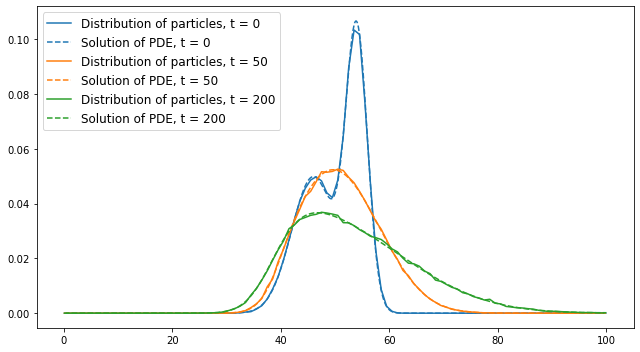

In [15]:
# Create histogram of distribution, at different times
# and plot with the analytical solution
fig = plt.figure(figsize = (9, 5))
bins, dx = np.linspace(0, 100, 101, retstep = True)
mids = bins[:-1] + dx/2

for t in [0, 50, 200]:
    # time index for random walk method
    it_EM = int(t / dt_EM)
    hist, _ = np.histogram(Xp[it_EM,:], bins = bins, density = True)
    l, = plt.plot(mids, hist, label = f'Distribution of particles, t = {t}')
    # time index for Crank-Nicolson method
    it_CN = int(t / dt_CN)
    plt.plot(X, C[it_CN,:], '--', c = l.get_color(), label = f'Solution of PDE, t = {t}')

plt.legend(loc = 'upper left', fontsize = 12)
plt.tight_layout()

## The Langevin equation

In the SDE for diffusion, that we used above, the *position* of the particle changes by random increments. This is equivalent to the particle always having a random velocity, where the velocity at time $t + \delta t$ is completely uncorrelated to the velocity at time $t$, no matter how small $\delta t$ is.

We will now look at a more realistic description of particle motion, proposed by Paul Langevin in 1908 (https://doi.org/10.1119/1.18725), as a model for the physical Brownian motion, observed when one looks a small particles suspened in a liquid.

We consider particles that are small (diameter less than about 0.1 $\mu$m), yet much, much larger than the molecules of the liquid. We assume that the particles are affected by two forces: A random force, representing the random collisions with the molecules of the liquid, and a drag force, representing friction from the bulk liquid. If we write down Newton's second law for such a particle, as originally proposed by Langevin, it reads:

$$ m \ddot{x} = -6 \pi \mu r \dot{x} + X. $$

Here, $m$ is the mass of the particle, $r$ is the radius, $-6 \pi \mu r \dot{x}$ is the drag on a small, spherical particle in a liquid with viscosity $\mu$ (https://en.wikipedia.org/wiki/Stokes%27_law), and $X$ is the random force, which is not specified too closely in the original paper (the theory of SDEs wasn't really developed properly until the work of Kiyosi Itô in the 1940s).

In modern notation, we can rewrite this equation into a pair of coupled first-order SDEs for the velocity and the position of the particle:

$$ \mathrm{d}x = v \, \mathrm{d}t \\
 \mathrm{d}v = -\frac{1}{\tau}v \, \mathrm{d}t + \eta \, \mathrm{d}W. $$

Here, $\tau$ is a timescale for decay of the velocity of the particle due to drag forces (found from Stokes' law), and $\eta$ is the strength of the random acceleration due to collisions with the molecules of the liquid. The value of $\eta$ will depend on the mass of the particle, and on the temperature and viscosity of the liquid.

### Note about terminology

The term "Langevin equation" is also used as a general description of SDEs that describe how some "slowly varying" property of a system changes in response to "fast fluctuations" in some other part of the system. Examples include noise in electronic circuits, Brownian motion in different potentials, magnetisation, etc.

Furthermore, a lot of work has been done on the process described by the original Langevin equation, most notably by Ornstein and Uhlenbeck. Consequently, the speed of the particle as described by the original Langevin equation is now known as an Ornstein-Uhlenbeck process.

For the interested reader, I suggest having a look at the book *The Langevin Equation* by Coffey & Kalmykov, and also a couple of papers by Gillespie:
* *The Langevin Equation*: https://www.worldscientific.com/worldscibooks/10.1142/10490
* The mathematics of Brownian motion and Johnson noise: https://aapt.scitation.org/doi/pdf/10.1119/1.18210
* Exact numerical simulation of the Ornstein-Uhlenbeck process and its integral: https://journals.aps.org/pre/abstract/10.1103/PhysRevE.54.2084

In [16]:
def langevin_SDE_one_step(X, t, dt, tau, eta):
    # Implements the original Langevin equation,
    # as a pair of coupled first-order SDEs.
    # X is a two-component vector:
    # X[0, :] is position
    # X[1, :] is velocity
    dW = np.random.normal(loc = 0, scale = np.sqrt(dt), size = X.shape[1])
    dx = X[1,:] * dt
    dv = -(1/tau)*X[1,:]*dt + eta*dW
    return X + np.array([dx, dv])

def langevin_SDE(X0, Tmax, dt, tau, eta):
    Nt = int(Tmax/dt)
    X = np.zeros((Nt+1, *X0.shape))
    X[0,:,:] = X0
    t = 0
    for i in trange(1, Nt+1):
        X[i,:] =  langevin_SDE_one_step(X[i-1,:], t, dt, tau, eta)
        t += dt
    return X

In [18]:
Tmax = 1000
tau = 2
eta = 1
dt = 0.01
Np = 1000
X0 = np.zeros((2, Np))

# Uncomment and run again to set initial speeds to be
# the speeds at the end of the previous run
#X0[1,:] = X[-1,1,:]

# Run calculation
X = langevin_SDE(X0, Tmax, dt, tau, eta)

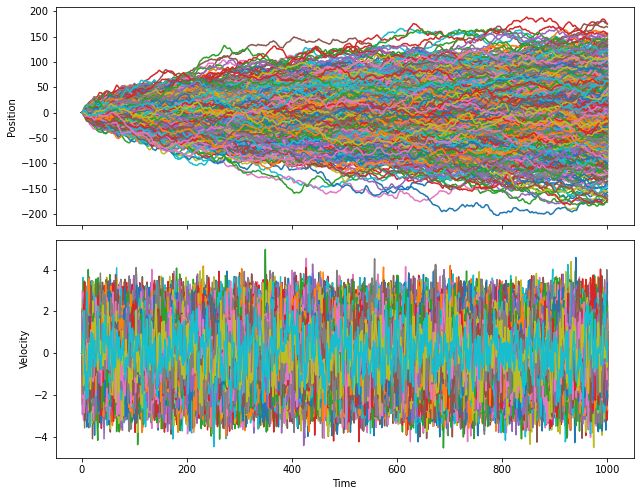

In [19]:
times = np.linspace(0, Tmax, X.shape[0])
fig, ax = plt.subplots(nrows = 2, figsize = (9, 7), sharex = True)
Nskip = 100
ax[0].plot(times[::Nskip], X[::Nskip,0,:])
ax[1].plot(times[::Nskip], X[::Nskip,1,:])
ax[0].set_ylabel('Position')
ax[1].set_ylabel('Velocity')
ax[1].set_xlabel('Time')
plt.tight_layout()

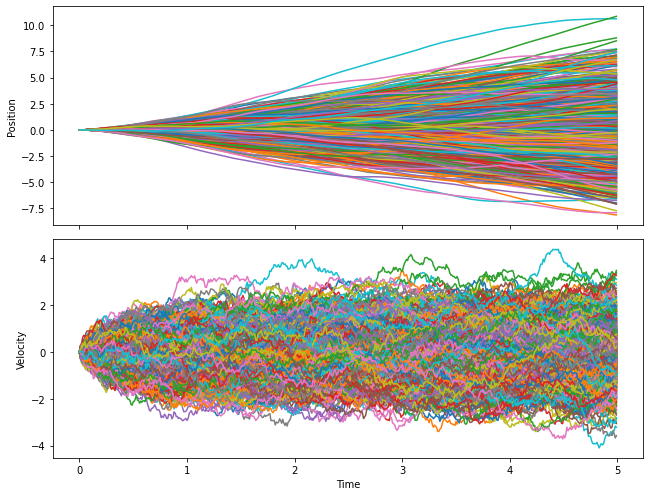

In [20]:
times = np.linspace(0, Tmax, X.shape[0])
fig, ax = plt.subplots(nrows = 2, figsize = (9, 7), sharex = True)
Nstop = 500
ax[0].plot(times[:Nstop], X[:Nstop,0,:])
ax[1].plot(times[:Nstop], X[:Nstop,1,:])
ax[0].set_ylabel('Position')
ax[1].set_ylabel('Velocity')
ax[1].set_xlabel('Time')
plt.tight_layout()

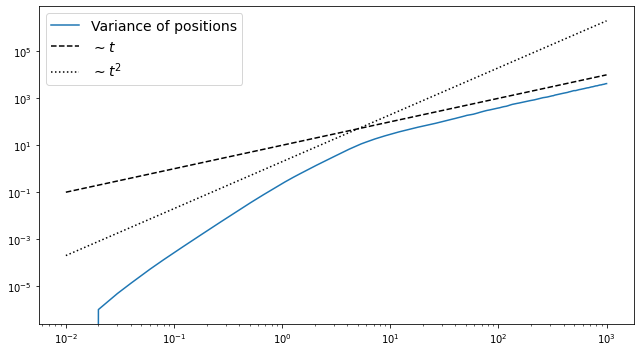

In [21]:
### Plot variance (mean square displacement)
times = np.linspace(0, Tmax, X.shape[0])
var = np.var(X[:,0,:], axis = 1)

fig = plt.figure(figsize = (9, 5))
plt.plot(times[1:], var[1:], label = 'Variance of positions')

plt.plot(times[1:], 10*times[1:], '--', c = 'k', label = '$\sim t$')
plt.plot(times[1:], 2*times[1:]**2, ':', c = 'k', label = '$\sim t^2$')
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize = 14)
plt.tight_layout()

## More general SDEs

More generally, SDEs are written on the form 

$$ \mathrm{d} x = a(x, t) \, \mathrm{d}t + b(x, t) \, \mathrm{d}W, $$

where $a(x, t)  \, \mathrm{d}t $ is called the drift coefficient, and $b(x, t) \, \mathrm{d}W $ is called the diffusion term, or noise term.


### The Fokker-Planck equation

Provided that $a(x, t)$ and $b(x, t)$ are sufficently smooth and well-behaved functions, there also exists a general PDE that describes how the distribution of solutions to the SDE will develop. This is called the Fokker-Planck equation, or sometimes the forward Kolmogorov equation:

$$ \frac{\partial p}{\partial t} = -\frac{\partial}{\partial x} \big( a(x, t) p(x, t) \big) + \frac{1}{2} \frac{\partial}{\partial x} \big( b^2(x, t) p(x, t) \big). $$


## Numerical schemes for SDEs

Just like for ODEs, there also exist a range of numerical methods for SDEs, but even low order scemes become complicated quite fast, and most schemes involve partial derivatives (with respect to position) of $a(x, t)$ and/or $b(x, t)$. A couple of examples are shown below. For additional examples, see the book *Numerical Solution of Stochastic Differential Equations* by Kloeden & Platen.


### The Euler-Maruyama scheme

The Euler-Maruyama scheme for the general SDE above reads

$$ x_{i+1} =  x_i + a(x_i, t_i) \, \Delta t + b(x_i, t_i) \, \Delta W. $$

The Euler-Mauryama scheme has order of convergence 1 in the weak sense, and 1/2 in the strong sense.


### The 1st-order Milstein scheme

$$ x_{i+1} =  x_i + a(x_i, t_i) \, \Delta t + b(x_i, t_i) \, \Delta W + b(x_i, t_i) b'(x_i, t_i) \big( \Delta W^2 - \Delta t \big),  $$

where $b'(x, t)$ is the partial derivative of $b(x,t)$ with respect to $x$.

The 1st-order Milstein scheme has order of convergence 1 in both the weak and the strong sense. We will not implement this scheme here, but rather consider a variant that contains a finite-difference approximation of the derivative of $b$:


### A strong 1st-order derivative-free scheme

This scheme was originally proposed by Eckhard Platen, and is a variant of the above that avoids calculating the derivative of $b$:

$$ x_{i+1} =  x_i + a(x_i, t_i) \, \Delta t + b(x_i, t_i) \, \Delta W + \frac{1}{2\sqrt{\Delta t}} \big( b(\hat{x}_i, t_i) - b(x_i, t_i) \big)\big( \Delta W^2 - \Delta t \big),  $$

where the so-called "supporting value" $\hat{x}_i$ is given by:

$$\hat{x}_i = x_i + a(x_i, t_i) \Delta t + b(x_i, t_i) \sqrt{\Delta t}.$$

The strong 1st-order derivative-free scheme due to Platen has order of convergence 1 on both the strong and the weak sense.

In [22]:
def EM(x, t, dt, a, b, dW = None):
    # Implements the Euler-Maruyama method for an SDE,
    # dx = a(x, t) dt + b(x, t) dW
    # following the same pattern we used for ODE methods
    # (see notebook 9 on ODEs)
    if dW is None:
        dW = np.random.normal(loc = 0, scale = np.sqrt(dt), size = x.shape)
    return x + a(x, t)*dt + b(x, t)*dW

def Platen(x, t, dt, a, b, dW = None):
    # Implements the 1st-order Milstein method for an SDE,
    # dx = a(x, t) dt + b(x, t) dW
    # following the same pattern we used for ODE methods
    # (see notebook 9 on ODEs)
    if dW is None:
        dW = np.random.normal(loc = 0, scale = np.sqrt(dt), size = x.shape)
    x_hat = x + a(x, t)*dt + b(x, t)*np.sqrt(dt)
    return x + a(x, t)*dt + b(x, t)*dW + (1/(2*np.sqrt(dt)))*(b(x_hat, t) - b(x,t))*(dW**2 - dt)

def trajectory(X0, Tmax, dt, a, b, scheme, W = None):
    # Define a trajectory function, like we did for ODEs
    # (see notebook 9 on ODEs)
    Nt = int(Tmax/dt)
    # Check that timestep divides Tmax
    assert np.abs(Tmax - dt*Nt)/Tmax < 1e-9
    X = np.zeros((Nt+1, X0.size))
    X[0,:] = X0
    t = 0
    for i in range(1,Nt+1):
        if W is not None:
            dW = W[i] - W[i-1]
        else:
            dW = None
        X[i,:] = scheme(X[i-1,:], t, dt, a, b, dW = dW)
        t += dt
    return X

def endpoints(X0, Tmax, dt, a, b, scheme, W = None):
    # Define a function to return endpoints only,
    # to use less memory (will be relevant later)
    Nt = int(Tmax/dt)
    # Check that timestep divides Tmax
    assert np.abs(Tmax - dt*Nt)/Tmax < 1e-9
    X = X0.copy()
    t = 0
    for i in range(1,Nt+1):
        if W is not None:
            dW = W[i] - W[i-1]
        else:
            dW = None
        X = scheme(X, t, dt, a, b, dW = dW)
        t += dt
    return X

## Convergence for SDE schemes

For SDEs, we have two different types of convergence: Convergence in the strong sense, and convergence in the weak sense.

### Strong convergence

Convergence in the strong sense means pathwise convergence. Assume that we have *a given realisation* of a Wiener process, $W_t$. As we saw above, we can take the increments $\Delta W$ of $W_t$, with different step lengths $\Delta t$. If we take the increments of $W_t$ at shorter and shorter intervals $\Delta t$, and use the increments as Gaussian random numbers in an SDE scheme, then strong convergence means that the solution converges to the correct solution for each realisation of $W_t$.

We say that an SDE scheme has order of convergence $\gamma$ in the strong sense, if

$$ \langle | x(T) - x_T(\Delta t) | \rangle < C \Delta t^\gamma $$

for sufficiently short $\Delta t$. Here, $C$ is a constant, $x(T)$ is the correct solution at time $T$, and $x_T(\Delta t)$ is the numerical approximation at the same time, obtained with a timestep $\Delta t$, and $\langle \ldots \rangle$ means an average over many realisations.

### Weak convergence

Convergence is the weak sense means convergence in distribution. This means that if we solve the same SDE many times (with different realisations of $W_t$ each time), then the distribution of solutions will converge to the correct distribution as we reduce the timestep. This is weaker than strong convergence since strong convergence implies weak convergence, but not the other way around.

We say that an SDE scheme has order of convergence $\gamma$ in the weak sense, if

$$ | \langle x(T) \rangle - \langle x_T(\Delta t) \rangle |  < C \Delta t^\gamma $$

for sufficiently short $\Delta t$. Here, $C$ is a constant, $x(T)$ is the correct solution at time $T$, and $x_T(\Delta t)$ is the numerical approximation at the same time, obtained with a timestep $\Delta t$, and $\langle \ldots \rangle$ means an average over many realisations.

### Demonstrating strong convergence

Strong convergence is a somewhat intricate consept. To demonstrate strong convergence in a purely numerical example where we don't have an analytical solution to compare to, we take the following steps:
* Decide on a shortest timestep, $\Delta t_{ref}$, which we want to use for the numerical reference solutions.
* Generate many realisations of $W_t$, with steplength $\Delta t_{ref}$.
* Calculate the reference solutions using the increments of $W_t$ and timestep $\Delta t_{ref}$.
* For each of the longer timesteps, $\Delta t$, we want to investigate, take the increments $W_{t+\Delta t} - W_t$ as the Gaussian random numbers in the SDE scheme.
* Plot the average of the absolute value of each error (solution minus reference solution) as a function of timestep.

In [23]:
# Define a(x, t) and b(x, t) for an SDE to use as example
# Choosing these to correspond to a diffusion problem

# Define diffusivity and derivative of diffusivity
a0, k0, k1, x0 = 0.25, 3e-2, 5e-1, 50
K = lambda x, t: k0 + (k1 - k0) * 1/(1 + np.exp(-a0*(x - x0)))
dKdz = lambda x, t: (a0 *(k0 - k1) *np.exp(a0* (x + x0)))/(np.exp(a0*x) + np.exp(a0*x0))**2
    
def a(x, t):
    return dKdz(x, t)

def b(x, t):
    return np.sqrt(2*K(x, t))

## First, illustrate the idea of strong convergence

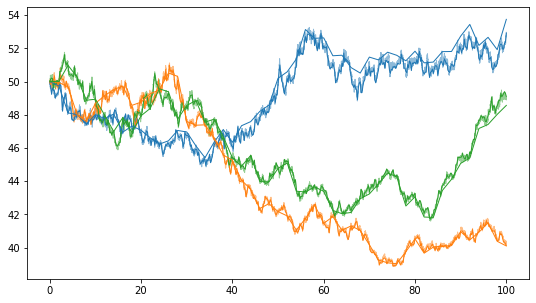

In [24]:
# Time to integrate to
Tmax = 100
# Shortest timestep and number of steps, for reference solution
dt_ref = 1e-2
Nt_ref = int(Tmax/dt_ref)
# Generate Np realisations of W_t
Np = 3
W_ref = np.zeros((Nt_ref+1, Np))
W_ref[1:,:] = np.cumsum( np.random.normal(loc = 0, scale = np.sqrt(dt_ref), size = (Nt_ref, Np)), axis=0)
T_ref = np.linspace(0, Tmax, Nt_ref+1)
# Initial positions
X0 = x0*np.ones(Np)

# Calculate reference solutions
X_ref = trajectory(X0, Tmax, dt_ref, a, b, Platen, W_ref)

# Calculate solutions for some other timesteps,
# defined as multiples of the reference timestep
multiples = np.array([20, 200])

# Arrays to hold solutions, for Euler-Maruyama and Platen
X_EM = []

for i, n in enumerate(multiples):
    # sub-sample wiener process
    W = W_ref[::n, :]
    # Calculate solutions for both schemes
    X_EM.append(trajectory(X0, Tmax, n*dt_ref, a, b, EM, W))


# Then, plot some examples
fig = plt.figure(figsize = (9, 5))
lines = plt.plot(T_ref, X_ref, lw = 1, alpha = 0.5)

for i, n in enumerate(multiples):
    # Using nested for-loops here, to get the colors to match
    for j, l in enumerate(lines):
        plt.plot(T_ref[::n], X_EM[i][:,j], lw = 1, c = l.get_color())

### Next, do a numerical investigation of strong convergence

In [25]:
# Time to integrate to
Tmax = 200
# Shortest timestep and number of steps, for reference solution
dt_ref = 1e-2
Nt_ref = int(Tmax/dt_ref)
# Generate Np realisations of W_t
Np = 1000
W_ref = np.zeros((Nt_ref+1, Np))
W_ref[1:,:] = np.cumsum( np.random.normal(loc = 0, scale = np.sqrt(dt_ref), size = (Nt_ref, Np)), axis=0)
# Initial positions
X0 = x0*np.ones(Np)

# Calculate reference solution, using endpoints function
# instead of trajectory to save memory)
X_ref = endpoints(X0, Tmax, dt_ref, a, b, Platen, W = W_ref)

# Calculate solutions for some other timesteps,
# defined as multiples of the reference timestep
multiples = np.array([10, 20, 50, 100, 200, 500, 1000, 2000])

# Arrays to hold solutions, for Euler-Maruyama and Platen
X_EM = np.zeros((len(multiples), Np))
X_P  = np.zeros((len(multiples), Np))

for i, n in enumerate(multiples):
    # sub-sample wiener process
    W = W_ref[::n, :]
    # Calculate solutions for both schemes
    X_EM[i,:] = endpoints(X0, Tmax, n*dt_ref, a, b, EM, W)
    X_P[ i,:] = endpoints(X0, Tmax, n*dt_ref, a, b, Platen, W)

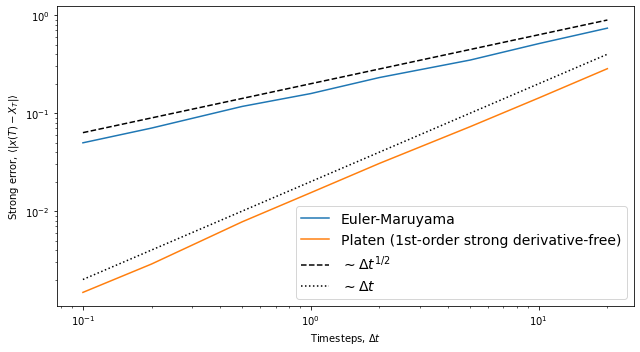

In [26]:
timesteps = dt_ref*multiples
errors_EM = np.mean( np.abs( X_EM - X_ref[None,:] ), axis = 1)
errors_P  = np.mean( np.abs( X_P  - X_ref[None,:] ), axis = 1)


fig = plt.figure(figsize = (9, 5))
plt.plot(timesteps, errors_EM, label = 'Euler-Maruyama')
plt.plot(timesteps, errors_P, label = 'Platen (1st-order strong derivative-free)')
plt.plot(timesteps, 0.2*timesteps**0.5, '--', c = 'k', label = '$\sim \Delta t^{1/2}$')
plt.plot(timesteps, 0.02*timesteps, ':', c = 'k', label = '$\sim \Delta t$')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Timesteps, $\Delta t$')
plt.ylabel('Strong error, $\langle | x(T)  - X_T | \\rangle$')
plt.legend(fontsize = 14)
plt.tight_layout()

### Demonstrating weak convergence

Weak convergence is easier to show than strong, as we don't have to keep using the same Wiener process. To demonstrate weak convergence in a purely numerical example where we don't have an analytical solution to compare to, we take the following steps:
* Calculate the reference solution using a short timestep $\Delta t_{ref}$.
* Calculate solutions with each of the longer timesteps, $\Delta t$, that we want to investigate.
* Plot the absolute value of the average numerical solution minus the average reference solution, as a function of timestep.

On the other hand, weak convergence is also more tricky, due to the fact that sampling error plays a greater role. Consider the expression for weak convergence:

$$ | \langle x(T) \rangle - \langle x_T(\Delta t) \rangle |  < C \Delta t^\gamma $$

When investigating weak convergence numerically, we are limited to using a finite number of samples. Hence, the two ensemble averages in the expression above contain a *sample error*. In addition, the numerical solution, $X_T(\Delta t)$, contains an error due to finite timestep. In order to investigate the error due to finite timestep, we need to make sure that the *sample error* is small enough, so that it does not swamp the results.

As you may recall from the discussion of Monte Carlo methods, we can estimate the sample error by means of the Central Limit Theorem (see also notebook 5):

The error in the sample mean is given by $E_N = \mu - \mu_N$, where $\mu$ is the *true* mean of the distribution (which will often be unknown), and $\mu_N$ is the mean of $X(T)$ based on $N$ samples. Then the Lindeberg-Lévy CLT says that the distribution of the error, $E_N$ in the sample mean is given by

$$ E_N \sim  \frac{1}{\sqrt{N}} \mathcal{N}(0, \sigma^2), $$

where $\mathcal{N}(0, \sigma^2)$ is a Gaussian distribution with zero mean and variance $\sigma^2$, and $\sigma^2$ is the (usually unknown) variance of the true distribution of $x(T)$.

In [27]:
# Define a(x, t) and b(x, t) for an SDE to use as example
# Choosing these to correspond to a diffusion problem

# Define diffusivity and derivative of diffusivity
a0, k0, k1, x0 = 0.5, 5e-3, 5e-2, 50
K = lambda x, t: k0 + (k1 - k0) * 1/(1 + np.exp(-a0*(x - x0)))
dKdz = lambda x, t: (a0 *(k0 - k1) *np.exp(a0* (x + x0)))/(np.exp(a0*x) + np.exp(a0*x0))**2
    
def a(x, t):
    return dKdz(x, t)

def b(x, t):
    return np.sqrt(2*K(x, t))

In [28]:
# Time to integrate to
Tmax = 200
# Shortest timestep and number of steps, for reference solution
dt_ref = 2e-1
# Number of realisations
Np = 100000
# Initial positions
X0 = x0*np.ones(Np)

# Calculate reference solution, using endpoints function
# instead of trajectory to save memory)
X_ref = endpoints(X0, Tmax, dt_ref, a, b, Platen)

# Calculate solutions for some other timesteps,
# defined as multiples of the reference timestep
multiples = np.array([10, 20, 50, 100, 200, 500, 1000])

# Arrays to hold solutions, for Euler-Maruyama and Platen
X_EM = np.zeros((len(multiples), Np))
X_P  = np.zeros((len(multiples), Np))

for i, n in enumerate(multiples):
    # Calculate solutions for both schemes
    X_EM[i,:] = endpoints(X0, Tmax, n*dt_ref, a, b, EM)
    X_P[ i,:] = endpoints(X0, Tmax, n*dt_ref, a, b, Platen)

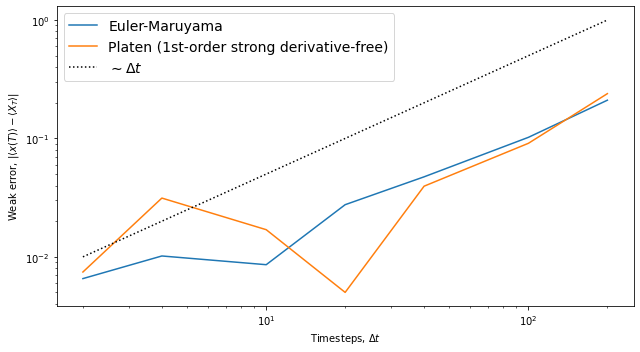

In [29]:
timesteps = dt_ref*multiples
errors_EM = np.abs( np.mean(X_EM, axis = 1) - np.mean(X_ref) )
errors_P  = np.abs( np.mean(X_P,  axis = 1) - np.mean(X_ref) )


fig = plt.figure(figsize = (9, 5))
plt.plot(timesteps, errors_EM, label = 'Euler-Maruyama')
plt.plot(timesteps, errors_P, label = 'Platen (1st-order strong derivative-free)')
plt.plot(timesteps, 0.005*timesteps, ':', c = 'k', label = '$\sim \Delta t$')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Timesteps, $\Delta t$')
plt.ylabel('Weak error, $ | \langle x(T) \\rangle  - \langle X_T \\rangle | $')
plt.legend(fontsize = 14)
plt.tight_layout()

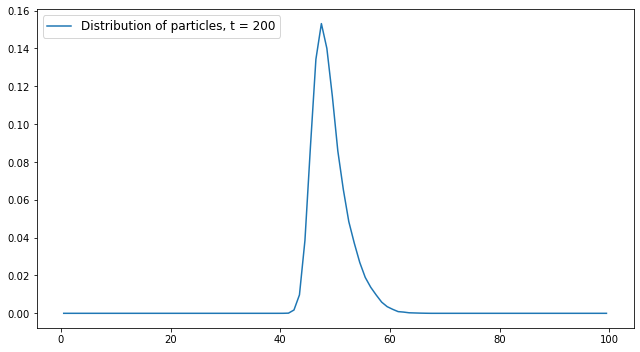

In [30]:
# Create histogram of distribution, at different times
# and plot with the analytical solution
fig = plt.figure(figsize = (9, 5))
bins, dx = np.linspace(0, 100, 101, retstep = True)
mids = bins[:-1] + dx/2

hist, _ = np.histogram(X_ref, bins = bins, density = True)
plt.plot(mids, hist, label = f'Distribution of particles, t = {Tmax}')

plt.legend(loc = 'upper left', fontsize = 12)
plt.tight_layout()

In [34]:
# Time to integrate to
Tmax = 400
# Shortest timestep and number of steps, for reference solution
dt_ref = 0.1
# Number of realisations
Np = 100000
# Number of sets of realisations
Nsets = 10
# Initial positions
X0 = x0*np.ones(Np)

# Calculate reference solution, using endpoints function
# instead of trajectory to save memory)
X_ref = endpoints(X0, Tmax, dt_ref, a, b, Platen)

# Calculate solutions for some other timesteps,
# defined as multiples of the reference timestep
multiples = np.array([20, 50, 100, 200, 500, 1000, 2000])

# Arrays to hold solutions, for Euler-Maruyama and Platen
X_EM = np.zeros((len(multiples), Nsets, Np))
X_P  = np.zeros((len(multiples), Nsets, Np))

for i, n in enumerate(multiples):
    for j in range(Nsets):
        # Calculate solutions for both schemes
        X_EM[i,j,:] = endpoints(X0, Tmax, n*dt_ref, a, b, EM)

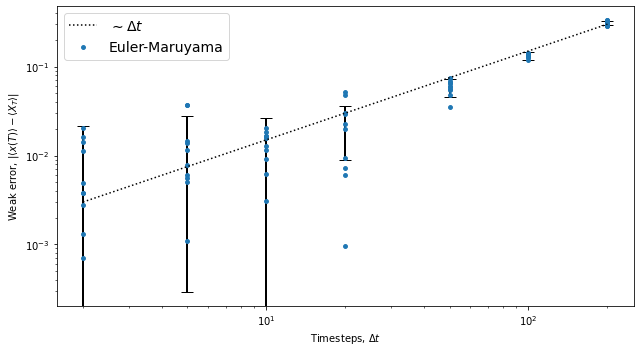

In [35]:
timesteps = dt_ref*multiples
errors_EM = np.abs( np.mean(X_EM, axis = 2) - np.mean(X_ref) )


fig = plt.figure(figsize = (9, 5))
for i in range(Nsets):
    if i == 0:
        plt.scatter(timesteps, errors_EM[:,i], s = 15, c = '#1f77b4', label = 'Euler-Maruyama')
    else:
        plt.scatter(timesteps, errors_EM[:,i], s = 15, c = '#1f77b4')
        

plt.plot(timesteps, 1.5e-3*timesteps, ':', c = 'k', label = '$\sim \Delta t$')

# Add error bars, based on Central limit theorem.
# Use the variance from the reference solution.
# Note that all the error bars have the same length,
# but they appear different due to the log scale.
var = np.var(X_ref)
for i, dt in enumerate(timesteps):
    plt.errorbar(dt, np.mean(errors_EM[i,:]), yerr = np.sqrt(var/Np), lw = 2, capsize = 6, c = 'k', zorder = -1)



plt.xscale('log')
plt.yscale('log')
plt.xlabel('Timesteps, $\Delta t$')
plt.ylabel('Weak error, $ | \langle x(T) \\rangle  - \langle X_T \\rangle | $')
plt.legend(fontsize = 14)
plt.tight_layout()